In [1]:
import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\32827\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss,Softmax
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from torch import cat, no_grad, manual_seed
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
import random

In [3]:
classifier_model = resnet18(pretrained=True)

c:\Users\32827\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\32827\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\32827/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.3MB/s]


In [20]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [21]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc3 = Linear(512,2)  # 1-dimensional output from QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = Linear(1,1)


    def forward(self, x):
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return cat((x, 1 - x), -1)

In [22]:
classifier_model.fc = Net(qnn4)

In [29]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
print(x_train.shape)
print(x_test.shape)
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
new_y_train = []
new_y_test = []
for i in range(0,len(y_train)):
    new_y_train.append(np.argmax(y_train[i]))

for i in range(0,len(y_test)):
    new_y_test.append(np.argmax(y_test[i]))

num_samples_train = 1000
num_samples_test = 1000
new_y_train = np.array(new_y_train)
new_y_test = np.array(new_y_test)

idx = []
for targets in range(2):
    classes = np.where(new_y_train == targets)[0]
    idx = np.append(idx,random.choices(classes,k = num_samples_train))
idx = idx.astype(int)

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

x_train = x_train[idx]
y_train = np.zeros((new_y_train[idx].size, new_y_train[idx].max() + 1))
y_train[np.arange(new_y_train[idx].size), new_y_train[idx]] = 1

idx = []
for targets in range(2):
    classes = np.where(new_y_test == targets)[0]
    idx = np.append(idx,random.choices(classes,k = num_samples_test))
idx = idx.astype(int)

x_test = x_test[idx]
y_test = np.zeros((new_y_test[idx].size, new_y_test[idx].max() + 1))
y_test[np.arange(new_y_test[idx].size), new_y_test[idx]] = 1

# x_test = x_test[0:num_samples_test]
# y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile']
print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
shape of x_train (2000, 3, 32, 32)
shape of y_train (2000, 2)


In [30]:
# Pretrained model
classifier_model.eval() # for evaluation
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             nb_classes=4,input_shape=(3,32,32),loss=criterion,
                             optimizer=optimizer)

In [42]:
import torch.optim as optim
classifier_model.train()
classifier.fit(x_train, y_train, nb_epochs=20, batch_size=4,verbose=2)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs: 100%|██████████| 20/20 [25:03<00:00, 75.17s/it]


In [43]:
base_class = "airplane"
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 2
Incorrectly classified: 8


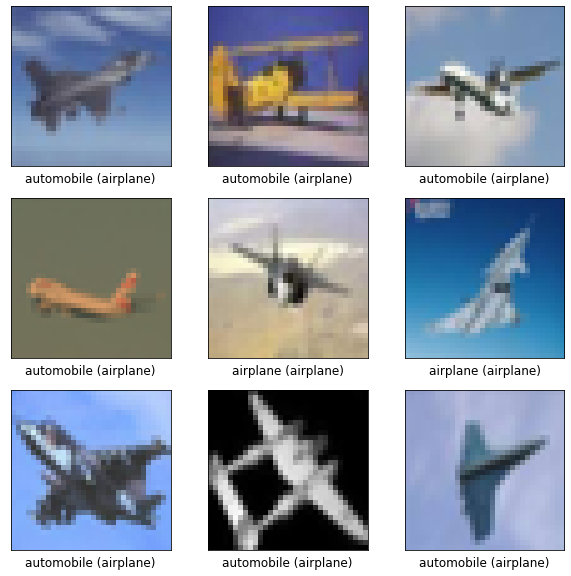

In [44]:
x_pred = np.argmax(classifier.predict(x_test), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(x_test[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

In [45]:
from sklearn import metrics

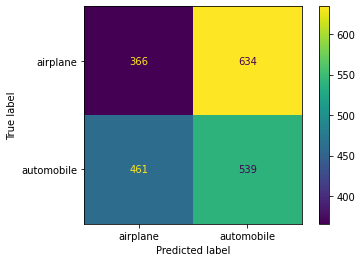

In [46]:
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test,axis=1), x_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_descr)

cm_display.plot()
plt.show()

In [47]:
Accuracy = metrics.accuracy_score(np.argmax(y_test,axis=1), x_pred)
print(Accuracy)

0.4525
